In [1]:
!pip install kaggle lightgbm shap polars duckdb pyarrow --quiet


In [2]:
from google.colab import files
files.upload()  # Upload your kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivajishaik","key":"d8fe966d4bb10ee2a40d02ede2a66756"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle competitions download -c home-credit-default-risk -p /content/data
!unzip /content/data/home-credit-default-risk.zip -d /content/data
!ls -lh /content/data


 95% 656M/688M [00:04<00:00, 134MB/s]
100% 688M/688M [00:04<00:00, 167MB/s]
Archive:  /content/data/home-credit-default-risk.zip
  inflating: /content/data/HomeCredit_columns_description.csv  
  inflating: /content/data/POS_CASH_balance.csv  
  inflating: /content/data/application_test.csv  
  inflating: /content/data/application_train.csv  
  inflating: /content/data/bureau.csv  
  inflating: /content/data/bureau_balance.csv  
  inflating: /content/data/credit_card_balance.csv  
  inflating: /content/data/installments_payments.csv  
  inflating: /content/data/previous_application.csv  
  inflating: /content/data/sample_submission.csv  
total 3.2G
-rw-r--r-- 1 root root  26M Dec 11  2019 application_test.csv
-rw-r--r-- 1 root root 159M Dec 11  2019 application_train.csv
-rw-r--r-- 1 root root 359M Dec 11  2019 bureau_balance.csv
-rw-r--r-- 1 root root 163M Dec 11  2019 bureau.csv
-rw-r--r-- 1 root root 405M Dec 11  2019 credit_card_balance.csv
-rw-r--r-- 1 root root  37K Dec 11  2019 H

In [5]:
#!kaggle competitions download -c home-credit-default-risk -p /content/data

In [6]:
#Load Data
import pandas as pd

train = pd.read_csv("/content/data/application_train.csv")
print(train.shape)
train.head()


(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#Quick Info Check
train.info()
train.describe()
train['TARGET'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


,proportion
TARGET,
0,0.919271
1,0.080729


In [8]:
#Missing Value Analysis
missing = train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing.head(10)


,0
COMMONAREA_AVG,214865
COMMONAREA_MODE,214865
COMMONAREA_MEDI,214865
NONLIVINGAPARTMENTS_MEDI,213514
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_AVG,213514
FONDKAPREMONT_MODE,210295
LIVINGAPARTMENTS_AVG,210199
LIVINGAPARTMENTS_MEDI,210199
LIVINGAPARTMENTS_MODE,210199


In [9]:
#Class Imbalance Check
train['TARGET'].value_counts(normalize=True)


,proportion
TARGET,
0,0.919271
1,0.080729


In [10]:
#Correlation Check
corr = train.corr(numeric_only=True)['TARGET'].sort_values(ascending=False)
corr.head(10), corr.tail(10)


(TARGET                         1.000000
 DAYS_BIRTH                     0.078239
 REGION_RATING_CLIENT_W_CITY    0.060893
 REGION_RATING_CLIENT           0.058899
 DAYS_LAST_PHONE_CHANGE         0.055218
 DAYS_ID_PUBLISH                0.051457
 REG_CITY_NOT_WORK_CITY         0.050994
 FLAG_EMP_PHONE                 0.045982
 REG_CITY_NOT_LIVE_CITY         0.044395
 FLAG_DOCUMENT_3                0.044346
 Name: TARGET, dtype: float64,
 ELEVATORS_AVG                -0.034199
 REGION_POPULATION_RELATIVE   -0.037227
 AMT_GOODS_PRICE              -0.039645
 FLOORSMAX_MODE               -0.043226
 FLOORSMAX_MEDI               -0.043768
 FLOORSMAX_AVG                -0.044003
 DAYS_EMPLOYED                -0.044932
 EXT_SOURCE_1                 -0.155317
 EXT_SOURCE_2                 -0.160472
 EXT_SOURCE_3                 -0.178919
 Name: TARGET, dtype: float64)

In [11]:
import pandas as pd

# Load train file
train = pd.read_csv("/content/data/application_train.csv")

print("Shape:", train.shape)
train.head()


Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


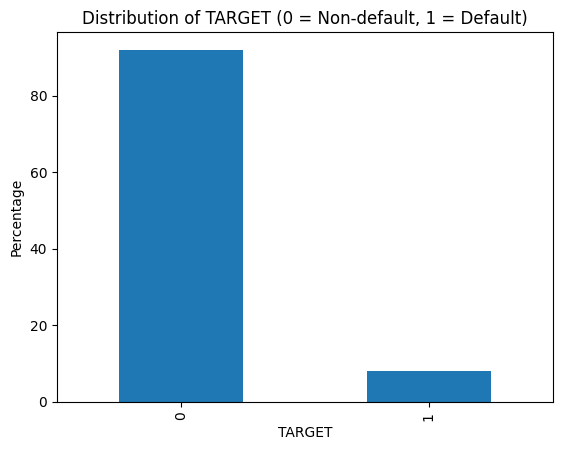

In [12]:
import matplotlib.pyplot as plt

target_counts = train['TARGET'].value_counts(normalize=True) * 100
print(target_counts)

target_counts.plot(kind='bar')
plt.title("Distribution of TARGET (0 = Non-default, 1 = Default)")
plt.ylabel("Percentage")
plt.show()


In [13]:
missing = train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print(missing.head(15))  # Top 15 missing features


COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
COMMONAREA_MEDI             214865
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_MODE       210199
FLOORSMIN_MODE              208642
FLOORSMIN_AVG               208642
FLOORSMIN_MEDI              208642
YEARS_BUILD_AVG             204488
YEARS_BUILD_MODE            204488
dtype: int64


In [14]:
num_features = train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = train.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", len(num_features))
print("Categorical features:", len(cat_features))


Numeric features: 106
Categorical features: 16


In [15]:
corr = train[num_features].corr(numeric_only=True)['TARGET'].sort_values(ascending=False)
print("Top positively correlated with default:\n", corr.head(10))
print("\nTop negatively correlated with default:\n", corr.tail(10))


Top positively correlated with default:
 TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
Name: TARGET, dtype: float64

Top negatively correlated with default:
 ELEVATORS_AVG                -0.034199
REGION_POPULATION_RELATIVE   -0.037227
AMT_GOODS_PRICE              -0.039645
FLOORSMAX_MODE               -0.043226
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_AVG                -0.044003
DAYS_EMPLOYED                -0.044932
EXT_SOURCE_1                 -0.155317
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_3                 -0.178919
Name: TARGET, dtype: float64


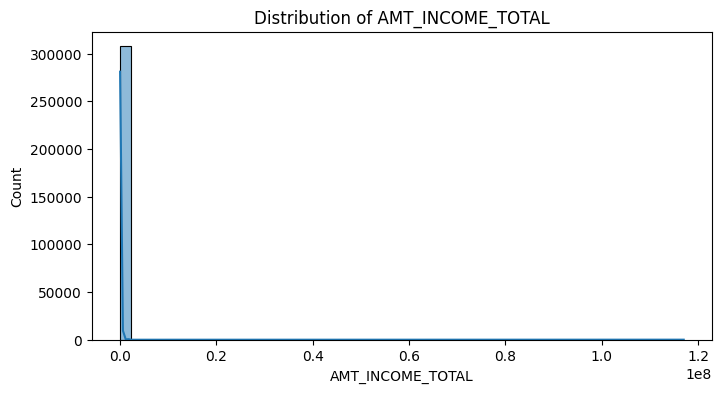

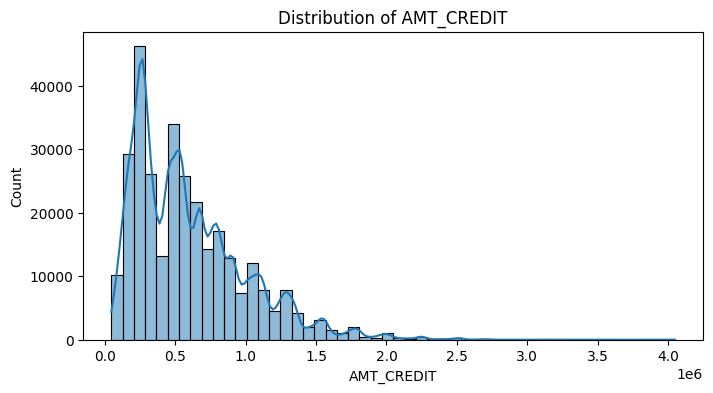

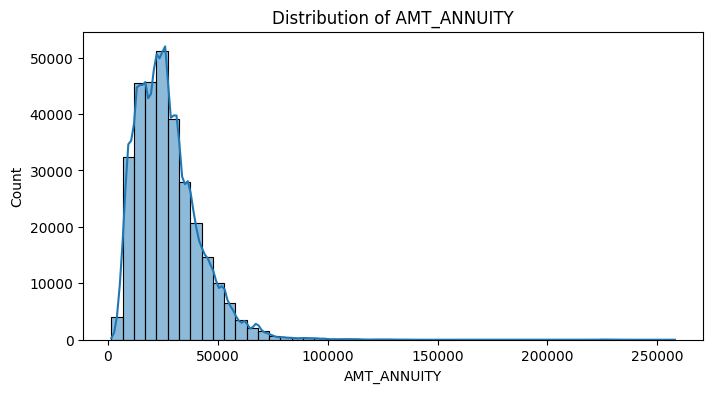

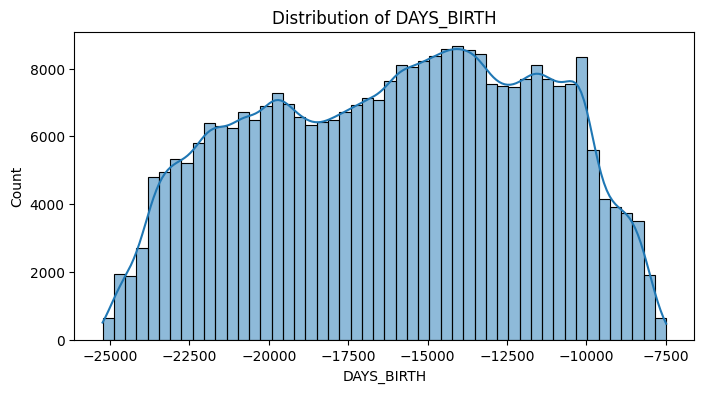

In [16]:
import seaborn as sns

features_to_plot = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH']

for f in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.histplot(train[f], bins=50, kde=True)
    plt.title(f"Distribution of {f}")
    plt.show()


In [17]:
high_corr = corr[abs(corr) > 0.2]
print("Potential leakage or strong predictors:\n", high_corr)


Potential leakage or strong predictors:
 TARGET    1.0
Name: TARGET, dtype: float64


In [18]:
# ===== Load Train & Test Data =====
import pandas as pd
import numpy as np

# Correct paths (inside /content/data)
train = pd.read_csv("/content/data/application_train.csv")
test = pd.read_csv("/content/data/application_test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (307511, 122)
Test shape: (48744, 121)


In [19]:
# ===== Missing Values + Encoding =====
from sklearn.preprocessing import LabelEncoder

# Copy dataset to avoid overwriting
train_clean = train.copy()
test_clean = test.copy()

# Replace placeholder values (like 365243) with NaN
for col in train_clean.columns:
    if (train_clean[col] == 365243).sum() > 0:
        train_clean[col].replace(365243, np.nan, inplace=True)
        if col in test_clean.columns:
            test_clean[col].replace(365243, np.nan, inplace=True)

# Encode categorical features
categorical_cols = train_clean.select_dtypes(include=['object']).columns

# Label Encoding (better for tree models like LightGBM)
le = LabelEncoder()
for col in categorical_cols:
    train_clean[col] = le.fit_transform(train_clean[col].astype(str))
    if col in test_clean.columns:
        test_clean[col] = le.transform(test_clean[col].astype(str))

print("Data cleaned & encoded!")
print("Train shape:", train_clean.shape)
print("Test shape:", test_clean.shape)


/tmp/ipython-input-2421789586.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_clean[col].replace(365243, np.nan, inplace=True)
/tmp/ipython-input-2421789586.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Data cleaned & encoded!
Train shape: (307511, 122)
Test shape: (48744, 121)


In [20]:
# ===== Train/Test Split =====
from sklearn.model_selection import train_test_split

X = train_clean.drop(columns=["TARGET"])
y = train_clean["TARGET"]

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "X_val:", X_val.shape)


X_train: (246008, 121) X_val: (61503, 121)


In [21]:
import lightgbm as lgb

# Prepare LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Parameters
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "verbose": -1
}

# Train with callback for early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)


Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.777983	valid's auc: 0.757389
[200]	train's auc: 0.803051	valid's auc: 0.760537
[300]	train's auc: 0.82284	valid's auc: 0.760584
[400]	train's auc: 0.839289	valid's auc: 0.760645
Early stopping, best iteration is:
[370]	train's auc: 0.834799	valid's auc: 0.760844


In [22]:
# Generate predictions on validation set
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


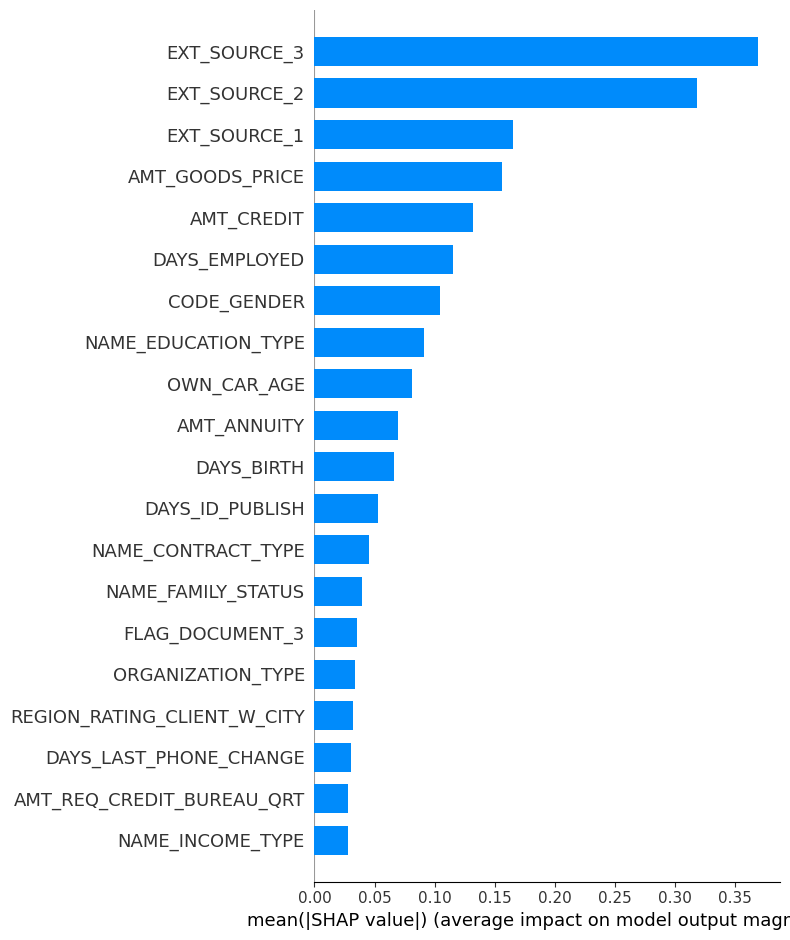

In [23]:
# ===== SHAP Explainability =====
import shap

# Use TreeExplainer for LightGBM
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# Summary plot (shows most important features)
shap.summary_plot(shap_values, X_val, plot_type="bar")


Average predicted default risk by gender:
 CODE_GENDER
0    0.070500
1    0.099131
2    0.088068
Name: PRED, dtype: float64


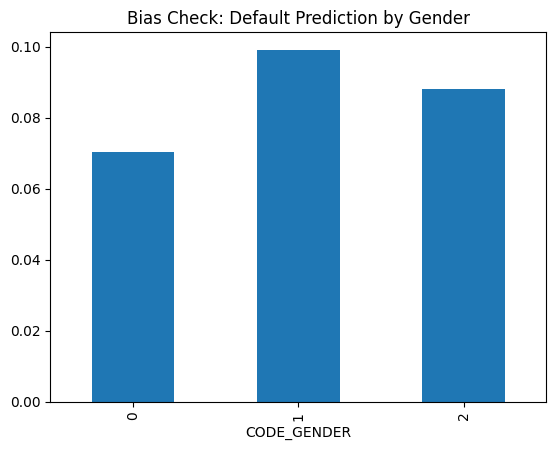

In [24]:
# ===== Fairness Check =====
# Example: check if gender (CODE_GENDER) affects predictions
import matplotlib.pyplot as plt

if "CODE_GENDER" in X_val.columns:
    X_val_with_preds = X_val.copy()
    X_val_with_preds["TARGET"] = y_val
    X_val_with_preds["PRED"] = y_val_pred

    gender_groups = X_val_with_preds.groupby("CODE_GENDER")["PRED"].mean()
    print("Average predicted default risk by gender:\n", gender_groups)

    gender_groups.plot(kind="bar", title="Bias Check: Default Prediction by Gender")
    plt.show()


In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Get predictions
y_val_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

# Metrics
auc = roc_auc_score(y_val, y_val_pred_proba)
acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred)
rec = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


AUC: 0.7608
Accuracy: 0.9197
Precision: 0.5767
Recall: 0.0220
F1-score: 0.0423


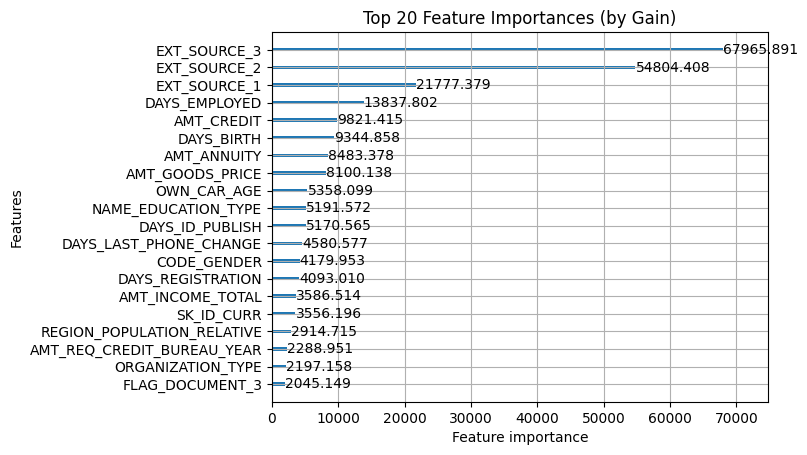

In [26]:
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=20, importance_type="gain")
plt.title("Top 20 Feature Importances (by Gain)")
plt.show()


In [27]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_scores = []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

    train_data_cv = lgb.Dataset(X_tr, label=y_tr)
    valid_data_cv = lgb.Dataset(X_val_cv, label=y_val_cv, reference=train_data_cv)

    model_cv = lgb.train(
        params,
        train_data_cv,
        valid_sets=[train_data_cv, valid_data_cv],
        valid_names=["train", "valid"],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
    )

    y_val_cv_pred_proba = model_cv.predict(X_val_cv, num_iteration=model_cv.best_iteration)
    auc_cv = roc_auc_score(y_val_cv, y_val_cv_pred_proba)
    cv_auc_scores.append(auc_cv)

print("Cross-Validation AUC scores:", cv_auc_scores)
print("Mean AUC:", np.mean(cv_auc_scores))


Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.783864	valid's auc: 0.750445
[200]	train's auc: 0.813191	valid's auc: 0.752709
Early stopping, best iteration is:
[204]	train's auc: 0.81393	valid's auc: 0.752747
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.781933	valid's auc: 0.75389
[200]	train's auc: 0.811374	valid's auc: 0.756335
Early stopping, best iteration is:
[203]	train's auc: 0.812175	valid's auc: 0.756395
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.783065	valid's auc: 0.75449
[200]	train's auc: 0.81167	valid's auc: 0.75759
Early stopping, best iteration is:
[203]	train's auc: 0.812471	valid's auc: 0.757698
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.782849	valid's auc: 0.754729
[200]	train's auc: 0.811909	valid's auc: 0.7577
[300]	train's auc: 0.83403	valid's auc: 0.758095
Early stopping, best iteration is:
[268]	train's auc: 0.827

In [28]:
# Assuming your raw test dataframe is 'test'
test_ids = test['SK_ID_CURR'].copy()


In [29]:
# Retrain on FULL training data
final_train_data = lgb.Dataset(X_train, label=y_train)
final_model = lgb.train(
    params,
    final_train_data,
    num_boost_round= model.best_iteration
)

# Predict on test set
test_pred_proba = final_model.predict(test_clean, num_iteration=final_model.best_iteration)

# Prepare submission
submission = pd.DataFrame({
    "SK_ID_CURR": test_ids,  # make sure you saved test IDs earlier
    "TARGET": test_pred_proba
})

submission.to_csv("submission.csv", index=False)
print("✅ Submission file saved as submission.csv")


✅ Submission file saved as submission.csv


In [30]:
# Inspect the original values in the 'CODE_GENDER' column
print(train['CODE_GENDER'].value_counts())

# You can also see how the label encoder mapped these values to 0, 1, and 2
# by looking at the `classes_` attribute of the label encoder object,
# but since the label encoder was created within a previous cell's scope,
# we'll just show the value counts from the original dataframe.

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64
